In [12]:
#!pip install ipdb
# import ipdb; ipdb.set_trace() # debugging starts here

# One-liner to start the debugger here.
#    from IPython.core.debugger import Tracer; Tracer()() 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import inv

\begin{align}
  x_{1,k+1} &= x_{1,k}+ T[ -\frac{b}{J}x_{1,k} + \frac{K_t}{J}x_{2,k} ]\\
  x_{2,k+1} &= x_{2,k}+ T[ -\frac{K_b}{L}x_{1,k} - \frac{R}{L}x_{2,k} ] + \frac{1}{L}u
\end{align}

$$e_{1,k} = x_{1,k}-x_{1d,k} $$
$$e_{1,k+1} = x_{1,k+1}-x_{1d,k+1} = x_{1,k}+ T[ -\frac{b}{J}x_{1,k} + \frac{K_t}{J}x_{2,k} ] - x_{1d,k+1} = k_1e_{1,k} $$

$$x_{d2,k} = \frac{J}{K_t}[\frac{-x_{1,k}+k_1e_{1,k}+ x_{1d,k+1}}{T} +\frac{b}{J}x_{1,k}]  $$

In [2]:
class MotorDc(object):
    # Propiedades del sistema
    J = 0.0167;
    b = 0.0167;
    Kb = 0.8;
    Kt = 0.8;
    R = 0.6;
    L = 0.012;
    T = 0.01;

    def __init__ (self,x0):
        # Estado Systema
        self.xk= x0 #np.array( [ [.5],[.3]]);
        self.x_k1= np.zeros_like(self.xk)
        self.f = np.zeros_like(self.xk)
        self.g = np.zeros_like(self.xk)
        
    
    def Sistema(obj,u):
        Gamma = 0

        Minterf = np.array([ [-obj.b / obj.J,  obj.Kt / obj.J],
                            [-obj.Kb / obj.L,  -obj.R / obj.L]] )
        
        obj.f = obj.xk + obj.T * Minterf @ obj.xk
        
        Minterg = np.array([[0], [1 / obj.L]])
        obj.g = obj.T*Minterg;
        
        obj.x_k1 = obj.f + obj.g* u + Gamma;
        obj.xk = obj.x_k1
        return obj.x_k1


In [64]:
class Control_Op(MotorDc):
    
    def __init__(self,x0,P):
        super(Control_Op,self).__init__(x0)
        self.P = P

    
    def Control(obj,Ref ):
        # Control optimo inverso
        hi=obj.g.T@obj.P@(obj.f-Ref);
        Ji=1/2*obj.g.T@obj.P@obj.g;        
        I=np.eye(*Ji.shape );           
        u=-1/2*inv(I +Ji)@hi;
        return u
        #u=-pinv(2 +Ji)*hi;


$$x_{d2,k} = \frac{J}{K_t}[\frac{-x_{1,k}+k_1e_{1,k}+ x_{1d,k+1}}{T} +\frac{b}{J}x_{1,k}]  $$

In [4]:
class System(object):
    
    def __init__(self,N,x0,P,x1ref ):
        self.x=np.empty( (2,N), dtype=float)
        self.x[:,[0] ] = x0
        self.P=P
        self.c = Control_Op(x0,P)
        self.x1ref = x1ref
        self.ke = .9
        
    def simular(self,k):
        ref = np.array( [ [self.x1ref[k]],[self.xd2Ref(k)] ])
        self.x[:,[k] ] = self.c.Sistema(self.c.Control(ref ))

    def xd2Ref(self,k):
        x1k = self.c.xk[0]
        e = x1k - self.x1ref[k]
        # self.x1ref[k] Modificar en un futuro a self.x1ref1[k], x_{1d,k+1}
        inter = ( -x1k + self.ke*e + self.x1ref[k] )/self.c.T
        
        return float ( (self.c.J / self.c.Kt)*inter + (self.c.b/self.c.J)*x1k )
        
        
    def grafica(self,t,edo1=False):
        if edo1 == False:
            plt.plot(t,self.x.T);
        else:
            plt.plot(t,self.x[0,:].T);

## Referencia

In [39]:
#Ref
fin = 5
T = MotorDc.T
t = np.arange(0,fin,T)
ref1 = np.sin(t*4)
#ref1k1 = np.sin(4*(t+T) )#4*np.cos(t*4)

#plt.plot(t,ref1)
#Ref
#ref2 = np.zeros_like(ref1)
#ref = np.stack( [ref1,ref2] )
#ref.shape

# Ganancia P aleatoria

0.0380061168739


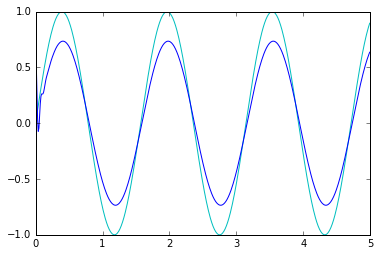

In [42]:
N= len(ref1)

mu, sigma = 10, 5 # mean and standard deviation
a1=np.random.normal(mu,sigma)
a2=np.random.normal(1,.5)
a3=np.random.normal(1,.5)
a4=1 #np.random.normal(10,2)

P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
x0 = np.array( [ [.5],[.3]])

s1 = System(N,x0,P,ref1)

#for k,inf in range(1,N):
for k,inf in enumerate(ref1):
    s1.simular(k)

plt.plot(t,ref1.T,'c-')
#plt.plot(t,ref1k1,'r-')
s1.grafica(t,edo1=True)
print (np.sum( (s1.x[0,:]-ref1)**2)/len(s1.x[0,:]) )

In [43]:
P

array([[ 10.98086765,   1.60488494],
       [  1.60488494,   1.29914834]])

# Utilizando PSO

In [44]:
from pyswarm import pso

In [45]:
def OPInv(p):
    a1=p[0]
    a2=p[1]
    a3=p[2]
    a4=1 #np.random.normal(10,2)

    P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
    x0 = np.array( [ [.5],[.3]])
    N= len(ref1)
    
    s1 = System(N,x0,P,ref1)

    for k,inf in enumerate(ref1):
        s1.simular(k)

    return (np.sum( (s1.x[0,:]-ref1)**2)/len(s1.x[0,:]) )

def con(x):
    a1 = x[0]
    a2 = x[1]
    a3 = x[2]
    P = np.array([ [a1,a2],[a2,a3]])
    w,_=np.linalg.eig(P)     
    return w>0

In [46]:
# Define the lower and upper bounds for H, d, t, respectively
lb = [1, 1,1]
ub = [20, 5,5]

xopt, fopt = pso(OPInv,lb,ub,swarmsize=100,f_ieqcons=con,omega=0.01,phip=0.01,maxiter=5)

Stopping search: maximum iterations reached --> 5


In [47]:
xopt

array([ 8.07881264,  3.74317971,  1.97122144])

0.0367084720433


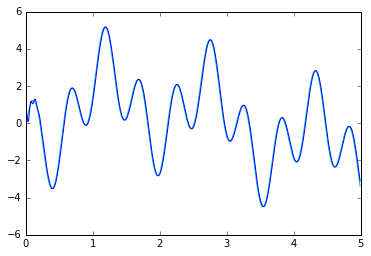

In [65]:
# Mod la referencia
fin = 5
T = MotorDc.T
t = np.arange(0,fin,T)
ref1 = 4*np.sin(t*4)*np.cos(t*8) + (4/np.pi)*np.sin(t)

N= len(ref1)
a1 = xopt[0]
a2 = xopt[1]
a3 = xopt[2]
a4=1 #np.random.normal(10,2)

P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
x0 = np.array( [ [.5],[.3]])

s1 = System(N,x0,P,ref1)

#for k,inf in range(1,N):
for k,inf in enumerate(ref1):
    s1.simular(k)

plt.plot(t,ref1.T,'c-')
#plt.plot(t,ref1k1,'r-')
s1.grafica(t,edo1=True)
print (np.sum( (s1.x[0,:]-ref1)**2)/len(s1.x[0,:]) )

In [61]:
w,_=np.linalg.eig(P)     
w,w>0

(array([ 9.85586189,  0.19417219]), array([ True,  True], dtype=bool))

In [ ]:
from sympy import *
init_printing()
var("X")

Fref = sin(4*X)
Fref,Fref.diff()

In [ ]:
import IPython.display as ipd
#ipd.Audio('audio/conga_groove.wav')

In [ ]:
sr = 22050 # sample rate
T = 2.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t)                # pure sine wave at 440 Hz

In [ ]:
ipd.Audio(x, rate=sr) # load a NumPy array